In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import scipy
import statsmodels.api as sm
from datetime import datetime
from pathlib import Path
import os

pd.options.display.max_columns = None
pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings(action="once")

# Reading in Dataframes + Preprocessing

In [2]:
COMMIT_HASH = "835aba8"
DATESTRING = datetime.strftime(datetime.today(), "%Y%m%d")

# DATA_DIR = f"../experiment_data_{COMMIT_HASH}/"
DATA_DIR = "."
OUTPUT_DIR = f"../outputs/outputs_{DATESTRING}_{COMMIT_HASH}"
path = Path(OUTPUT_DIR)
path.mkdir(parents=True, exist_ok=True)

# DATAFILENAMES = os.listdir(DATA_DIR)
DATAFILENAMES = ["0123_results835aba8.pkl", "Jan21_summary3112ffd.pkl"]

print(DATAFILENAMES)

DF_LIST = [
    pd.read_pickle(f"{DATA_DIR}/{filename}") for filename in DATAFILENAMES
]

COL_NUM_LAYERS = "num_layers"
COL_NUM_UNITS = "num_units"
COL_LOGN = "$\\log n$"
COL_LAMLOGN = "$-\\lambda \\log n$"
COL_H = "$H$"
COL_ELBO_S = "ELBO+$nS_n$"
COL_DIMW = "$dim_w$"
COL_DIMQ = "$dim_q$"
COL_LAMBDA = "$\\lambda$"
COL_SEED = "seed"
COL_ELBO_SHAT = "ELBO+$n\\hat S_n$"
COL_TESTLPD = "test_lpd"
COL_LR = "lr"

COL_MVFE = "normalized MVFE"
COL_VGE = "VGE"


FILENAME_PREFIX_DICT = {
    COL_ELBO_S: "ELBO_nS_vs_logn", 
    COL_ELBO_SHAT: "ELBO_nShat_vs_logn",
    COL_TESTLPD: f"{COL_TESTLPD}_vs_logn", 
    COL_MVFE: "MVFE_vs_logn", 
    COL_VGE: "VGE_vs_inverse_n",
}

DISABLE_SAVEFIG = True

def savefig(fig, filename):
    if not DISABLE_SAVEFIG:
        fig.savefig(os.path.join(OUTPUT_DIR, filename), bbox_inches="tight")
    return 

['0123_results835aba8.pkl', 'Jan21_summary3112ffd.pkl']


In [3]:
df_raw = pd.concat(DF_LIST)

rec = []
for method in df_raw["method"]:
    s = [entry.strip("\\") for entry in method.split("_")]
    num_layers, layer_width = s[-2:]
    m = s[0]
    rec.append([m, int(num_layers), int(layer_width)])

df_raw[["base_dist", COL_NUM_LAYERS, COL_NUM_UNITS]] = rec

INDEX_COLS = ["dataset", "base_dist", COL_NUM_LAYERS, COL_NUM_UNITS]

## Filtering

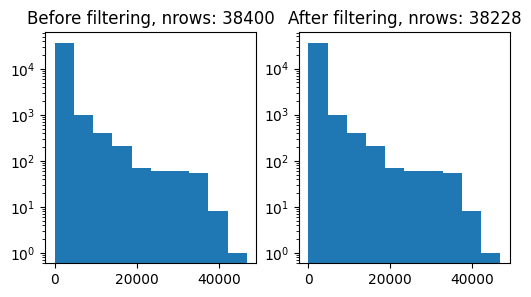

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# threshold = 1e6
# df = df_raw[df_raw[COL_MVFE] < threshold]

df = None

groupby_cols = INDEX_COLS + [COL_H, COL_LOGN, COL_LR]
for name, g in df_raw.groupby(groupby_cols): 
    mean = np.mean(g[COL_MVFE])
    filter_flag = np.abs(g[COL_MVFE] - mean) / mean <= 0.8
    if df is None:
        df = g[filter_flag]
    else:
        df = pd.concat([df, g[filter_flag]])

ax = axes[0]
ax.hist(df_raw[COL_MVFE]);
ymin, ymax = ax.get_ylim()
# ax.vlines([threshold], ymin=ymin, ymax=ymax, color="r")
ax.set_yscale("log");
ax.set_title(f"Before filtering, nrows: {df_raw.shape[0]}")

ax = axes[1]
ax.hist(df[COL_MVFE]);
ax.set_yscale("log");
ax.set_title(f"After filtering, nrows: {df.shape[0]}")

df_data = df.set_index(INDEX_COLS)
df_data[COL_LOGN] = np.around(df_data[COL_LOGN], decimals=4)

## Group dataframe and take statistics (e.g. mean, median, std, etc... ) over rng seeds

In [6]:
df_group = df_data.reset_index().drop("method", axis=1).groupby(
    INDEX_COLS + [COL_LR, COL_H, COL_LOGN]
).aggregate(["mean", "std", "min", "median", "max"])
df_group = df_group.reset_index().set_index(INDEX_COLS)
df_group

lr  $H$ $\log n$ $dim_w$   
                                                                     mean   
dataset       base_dist num_layers num_units                                
ffrelu        gaussian  2          4          0.001    3   6.9078    42.0  \
                                   4          0.001    3   7.0867    42.0   
                                   4          0.001    3   7.2661    42.0   
                                   4          0.001    3   7.4448    42.0   
                                   4          0.001    3   7.6241    42.0   
...                                             ...  ...      ...     ...   
tanh_zeromean gengamma  4          16         0.001  280   7.8030   560.0   
                                   16         0.001  280   7.9824   560.0   
                                   16         0.001  280   8.1614   560.0   
                                   16         0.001  280   8.3405   560.0   
                                   16         0.001  280   8.5196   560.0   

                                                                   $\lambda$   
                                              std  min median  max      mean   
dataset       base_dist num_layers num_units                                   
ffrelu        gaussian  2          4          0.0   42   42.0   42       NaN  \
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
...                                           ...  ...    ...  ...       ...   
tanh_zeromean gengamma  4          16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   

                                                                        
                                              std       min    median   
dataset       base_dist num_layers num_units                            
ffrelu        gaussian  2          4          NaN       NaN       NaN  \
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
...                                           ...       ...       ...   
tanh_zeromean gengamma  4          16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   

                                                        seed                 
                                                   max  mean       std min   
dataset       base_dist num_layers num_units                                 
ffrelu        gaussian  2          4               NaN  15.5  8.803408   1  \
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
...                                                ...   ...       ...  ..   
tanh_zeromean gengamma  4          16         8.363636  15.5  8.803408   1   
                                   16         

## Ascertain which learning rate is best for each (base dist, H, method) combo. 

lr
dataset       base_dist num_layers num_units $H$ $\log n$       
ffrelu        gaussian  2          4         3   6.9078    0.001
                                                 7.0867    0.001
                                                 7.2661    0.001
                                                 7.4448    0.001
                                                 7.6241    0.001
...                                                          ...
tanh_zeromean gengamma  4          16        280 7.8030    0.001
                                                 7.9824    0.001
                                                 8.1614    0.001
                                                 8.3405    0.001
                                                 8.5196    0.001

[1280 rows x 1 columns]

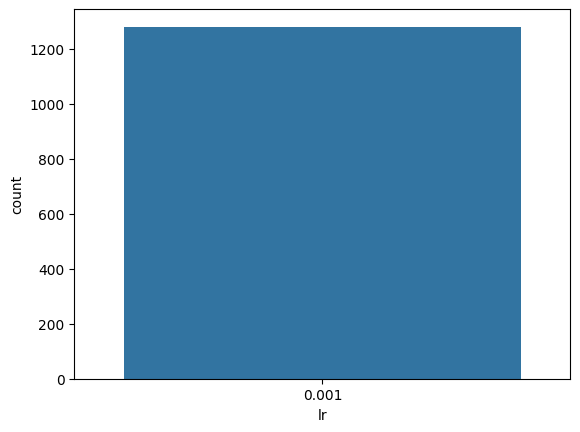

In [7]:
df = df_group.reset_index().set_index(INDEX_COLS + [COL_H, COL_LOGN])
# this is for old data format. 
# df = df.loc[:, [(COL_LR, ''), (COL_ELBO_S, "max"), (COL_ELBO_S, "mean"), (COL_ELBO_S, "median")]]

df = df.loc[:, [(COL_LR, ''), (COL_MVFE, "min"), (COL_MVFE, "mean"), (COL_MVFE, "median")]]

best_lr_rec = []
for idx in df.index.unique():
    x = df.loc[[idx]]
    best_lr = x.iloc[0, 0]
    best_data = tuple(x.iloc[0, 1:])
    for _, row in x.iterrows():
        row = np.array(row)
        if tuple(row[1:]) < best_data:
            best_lr = row[0].item()
            best_data = tuple(row[1:])
            
    best_lr_rec.append(list(idx) + [best_lr])

df_best_lr = pd.DataFrame(best_lr_rec, columns=list(df.index.names) + [COL_LR])
df_best_lr = df_best_lr.set_index(df.index.names)

sns.countplot(data=df_best_lr, x="lr")

df_best_lr

## Filter grouped dataframe with preferred learning rate

In [8]:
mode_rec = []

groupby_cols = ["dataset", "base_dist", COL_NUM_LAYERS, COL_NUM_UNITS, COL_H]

for idx, g in df_best_lr.reset_index().groupby(groupby_cols):
    preferred_lrs = list(g[COL_LR])
    chosen_lr = max(set(preferred_lrs), key=preferred_lrs.count) # mode of the lr's in the group. 
    mode_rec.append(list(idx) + [chosen_lr])
    

df_group = df_group.reset_index().set_index(groupby_cols + [COL_LR]).loc[mode_rec].reset_index().set_index(INDEX_COLS)
df_group

$H$     lr $\log n$ $dim_w$   
                                                                     mean   
dataset       base_dist num_layers num_units                                
ffrelu        gaussian  2          4            3  0.001   6.9078    42.0  \
                                   4            3  0.001   7.0867    42.0   
                                   4            3  0.001   7.2661    42.0   
                                   4            3  0.001   7.4448    42.0   
                                   4            3  0.001   7.6241    42.0   
...                                           ...    ...      ...     ...   
tanh_zeromean gengamma  4          16         280  0.001   7.8030   560.0   
                                   16         280  0.001   7.9824   560.0   
                                   16         280  0.001   8.1614   560.0   
                                   16         280  0.001   8.3405   560.0   
                                   16         280  0.001   8.5196   560.0   

                                                                   $\lambda$   
                                              std  min median  max      mean   
dataset       base_dist num_layers num_units                                   
ffrelu        gaussian  2          4          0.0   42   42.0   42       NaN  \
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
...                                           ...  ...    ...  ...       ...   
tanh_zeromean gengamma  4          16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   

                                                                        
                                              std       min    median   
dataset       base_dist num_layers num_units                            
ffrelu        gaussian  2          4          NaN       NaN       NaN  \
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
...                                           ...       ...       ...   
tanh_zeromean gengamma  4          16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   

                                                        seed                 
                                                   max  mean       std min   
dataset       base_dist num_layers num_units                                 
ffrelu        gaussian  2          4               NaN  15.5  8.803408   1  \
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
...                                                ...   ...       ...  ..   
tanh_zeromean gengamma  4          16         8.363636  15.5  8.803408   1   
                                   16      

## Compute a "line score" for each (dataset, base dist, n, m, H) combination
This will later help with de-cluttering the plots by ploting the lines with best score in each `(dataset, base dist, H)` combination

In [9]:
groupby_cols = INDEX_COLS + [COL_H]
group = df_group.groupby(groupby_cols)

rec = {}
for name, g in group:
    y = g[(COL_MVFE, "mean")]
    line_score = np.sum(np.abs(y))
    rec[name] = line_score

x = []
for idx, row in df_group.iterrows():
    key = tuple(list(idx) + [row[COL_H].item()])
    x.append(rec[key])
df_group["line_score"] = x
df_group

$H$     lr $\log n$ $dim_w$   
                                                                     mean   
dataset       base_dist num_layers num_units                                
ffrelu        gaussian  2          4            3  0.001   6.9078    42.0  \
                                   4            3  0.001   7.0867    42.0   
                                   4            3  0.001   7.2661    42.0   
                                   4            3  0.001   7.4448    42.0   
                                   4            3  0.001   7.6241    42.0   
...                                           ...    ...      ...     ...   
tanh_zeromean gengamma  4          16         280  0.001   7.8030   560.0   
                                   16         280  0.001   7.9824   560.0   
                                   16         280  0.001   8.1614   560.0   
                                   16         280  0.001   8.3405   560.0   
                                   16         280  0.001   8.5196   560.0   

                                                                   $\lambda$   
                                              std  min median  max      mean   
dataset       base_dist num_layers num_units                                   
ffrelu        gaussian  2          4          0.0   42   42.0   42       NaN  \
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
                                   4          0.0   42   42.0   42       NaN   
...                                           ...  ...    ...  ...       ...   
tanh_zeromean gengamma  4          16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   
                                   16         0.0  560  560.0  560  8.363636   

                                                                        
                                              std       min    median   
dataset       base_dist num_layers num_units                            
ffrelu        gaussian  2          4          NaN       NaN       NaN  \
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
                                   4          NaN       NaN       NaN   
...                                           ...       ...       ...   
tanh_zeromean gengamma  4          16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   
                                   16         0.0  8.363636  8.363636   

                                                        seed                 
                                                   max  mean       std min   
dataset       base_dist num_layers num_units                                 
ffrelu        gaussian  2          4               NaN  15.5  8.803408   1  \
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
                                   4               NaN  15.5  8.803408   1   
...                                                ...   ...       ...  ..   
tanh_zeromean gengamma  4          16         8.363636  15.5  8.803408   1   
                                   16      

# Plotting

In [10]:
def _transpose_list(x):
    return list(map(list, zip(*x)))


In [28]:
mask = (df_plot.index.get_level_values("num_layers") == 2) & (df_plot.index.get_level_values("num_units") == 4)
df_plot[mask]

NameError: name 'df_plot' is not defined

Image filename: VGE_vs_inverse_n_gengamma_gaussian.png


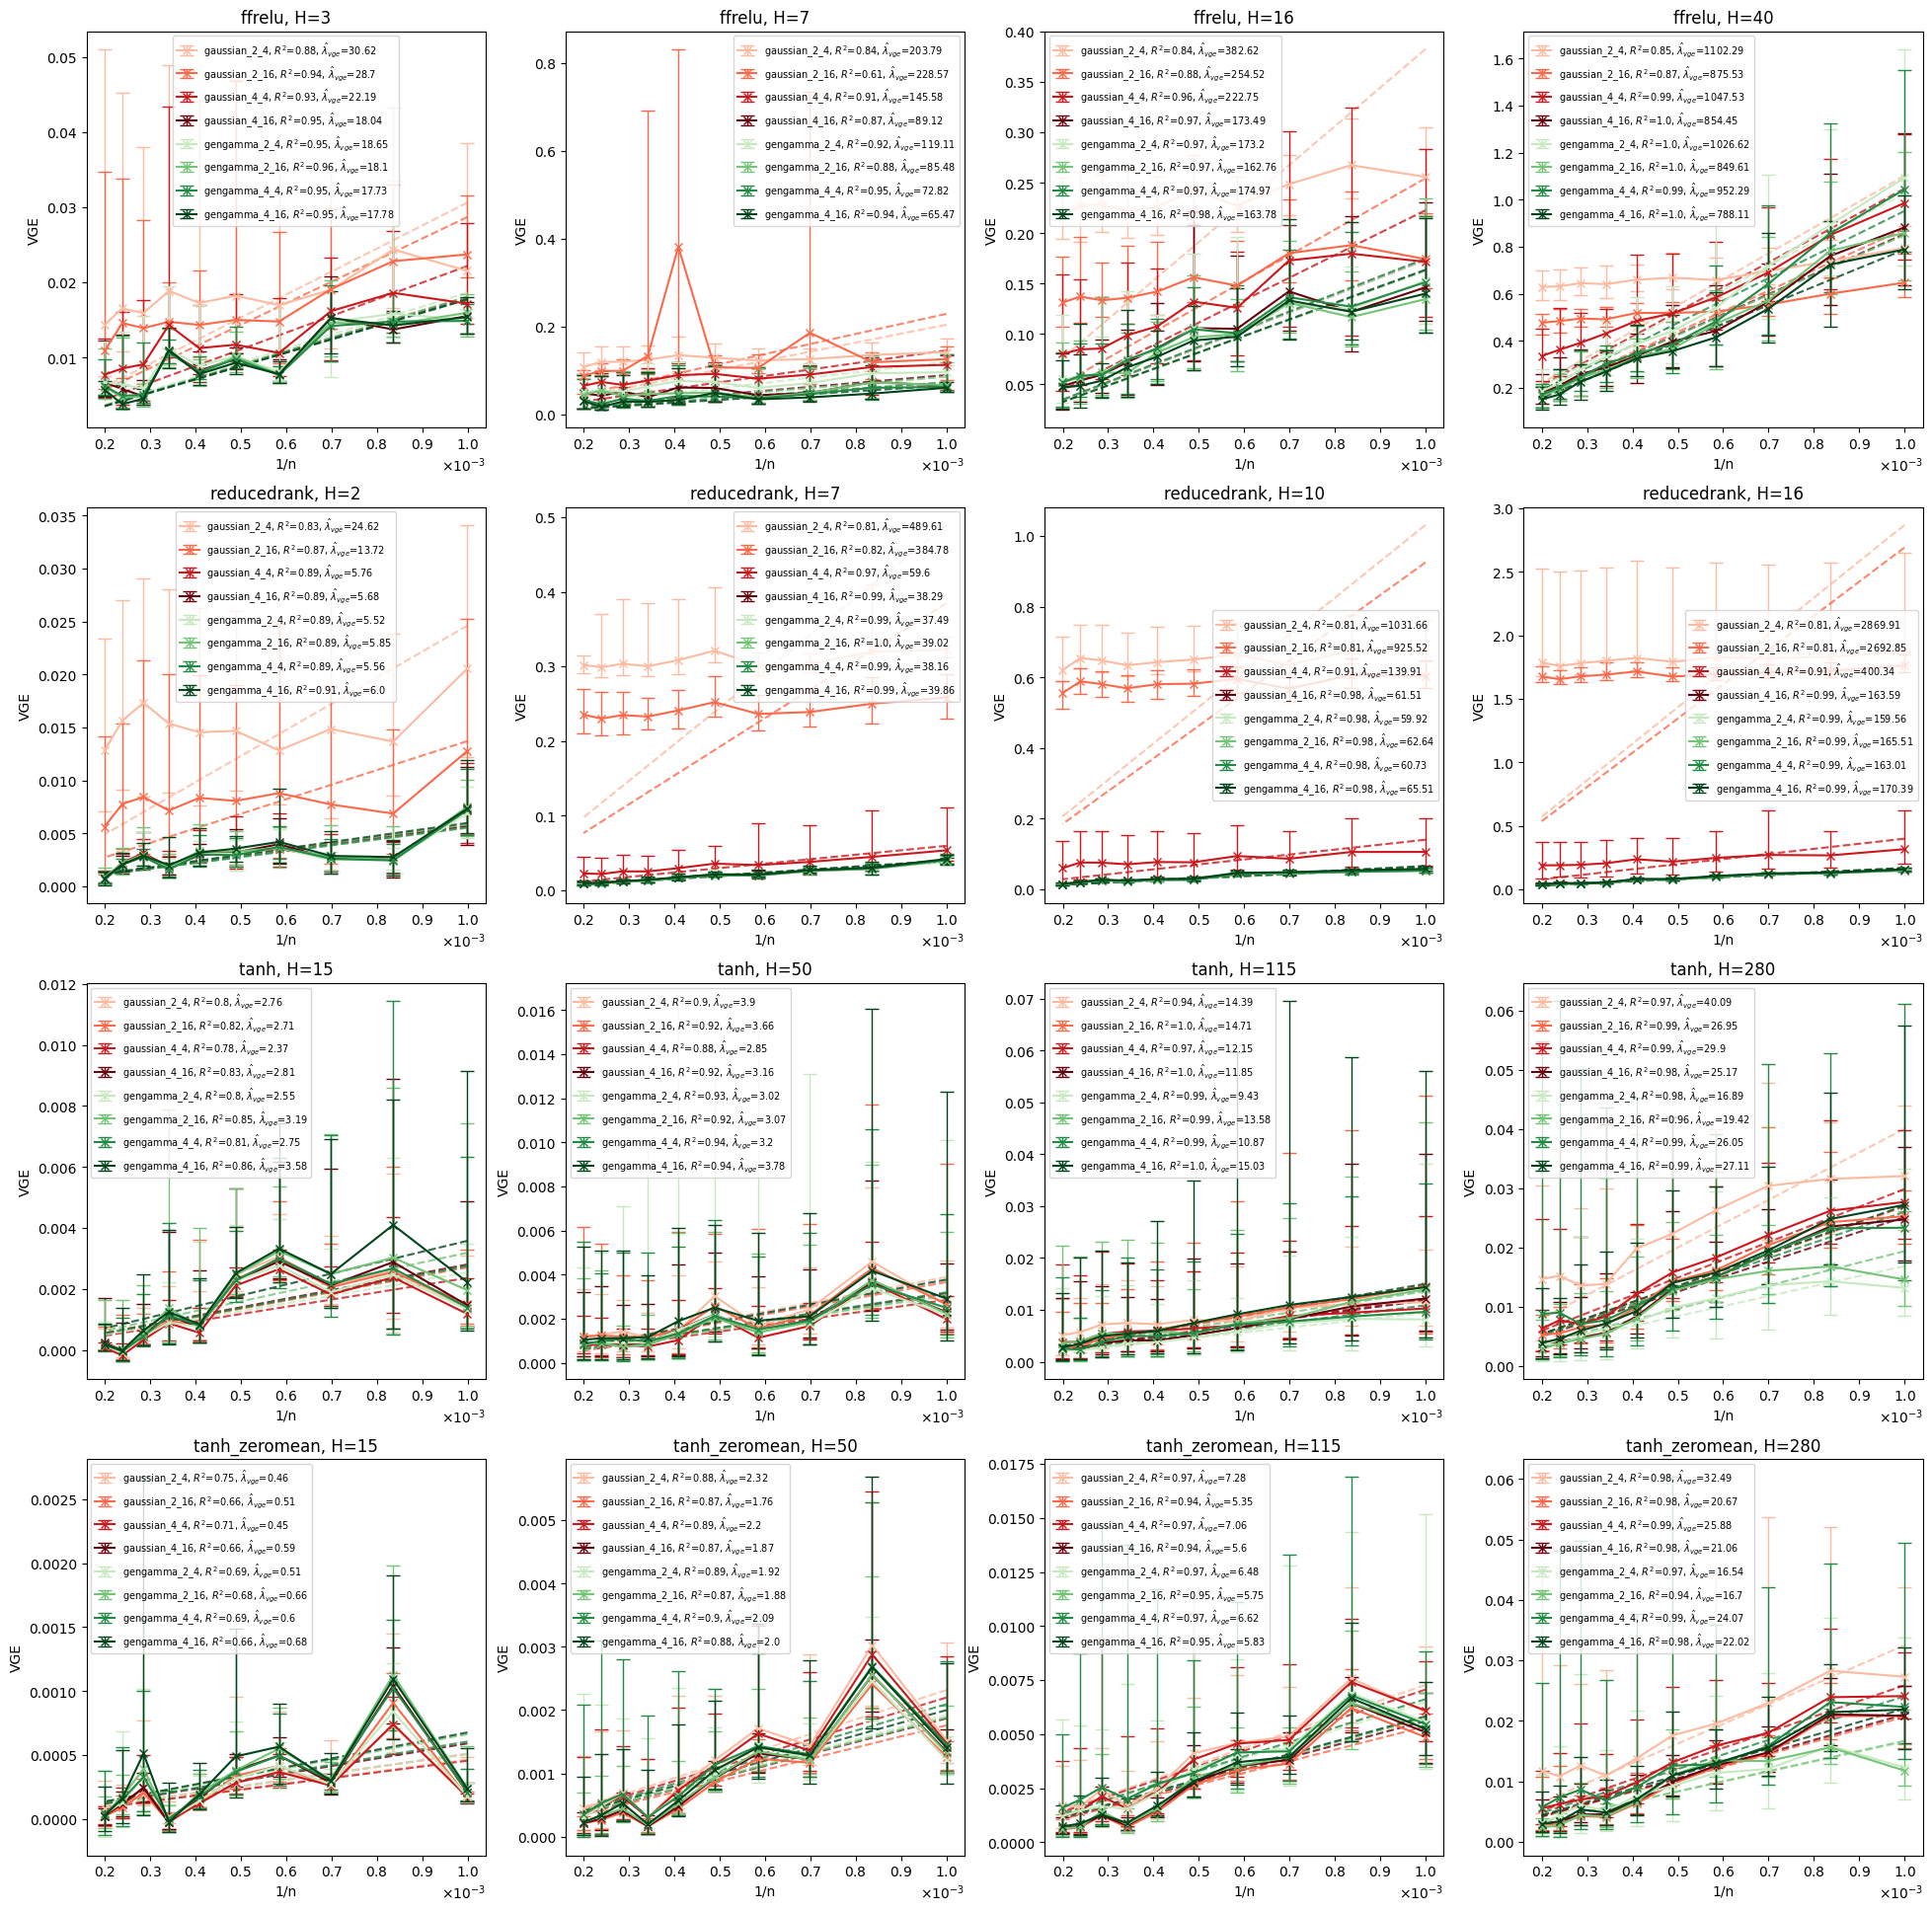

In [210]:
# Plot settings
PLOT_ONLY = [
    "gengamma", 
    "gaussian"
]
PLOT_BEST_LINE_ONLY = False
# PLOT_YVAR = COL_ELBO_SHAT
# PLOT_YVAR = COL_ELBO_S
# PLOT_YVAR = COL_TESTLPD
# PLOT_YVAR = COL_MVFE
PLOT_YVAR = COL_VGE

PLOT_STATS = "mean"

slope_var_name_dict = {
    COL_MVFE: "$\\hat{\\lambda}_{vfe}$", 
    COL_VGE: "$\\hat{\\lambda}_{vge}$", 
}
SLOPE_VAR_NAME = slope_var_name_dict.get(PLOT_YVAR, "slope")

PLOT_TRUE_LAMBDA_LINE = False
PLOT_LEAST_SQUARE_LINE = True
FORCE_ZERO_INTERCEPT = True


# Slicing out plotting data base on settings.
dataset_types = sorted(set([x[0] for x in df_group.index]))
plot_grid = []
for dataset in dataset_types:
    df = df_group.loc[dataset]
    row = []
    for h in sorted(df[COL_H].unique()):
        row.append((dataset, h))
    plot_grid.append(row)

# Uncomment for plotting for main text in paper. 
# plot_grid = [
#     [("ffrelu", 40, COL_MVFE), ("ffrelu", 40, COL_VGE), ], 
#     [("reducedrank", 16, COL_MVFE), ("reducedrank", 16, COL_VGE)], 
#     [("tanh", 280, COL_MVFE), ("tanh", 280, COL_VGE)]
# ]
# plot_grid = _transpose_list(plot_grid)


basedist_color_map = {
    "gengamma": "Greens",
    "gaussian": "Reds"
}


idx_filtered = df_group.index.get_level_values(1).isin(PLOT_ONLY)
df_plot = df_group[idx_filtered]

if PLOT_BEST_LINE_ONLY: 
    df_chosen = None
    groupby_cols = ["dataset", "base_dist", COL_H]
    for name, df in df_plot.groupby(groupby_cols):
        chosen_rows = df[df["line_score"] == df["line_score"].min()]
        if df_chosen is None:
            df_chosen = chosen_rows
        else:
            df_chosen = pd.concat([df_chosen, chosen_rows])
    df_plot = df_chosen


# df_plot = df_plot[
#     df_plot.index.get_level_values(2).isin([2])
#     & df_plot.index.get_level_values(3).isin([4])
# ]


# start plotting 
num_rows = len(plot_grid)
num_cols = len(plot_grid[0])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows), sharex=False)
if len(axes.shape) == 1:
    axes = axes.reshape(-1, 1)

rec = {COL_MVFE: [], COL_VGE: []}
for i in range(num_rows):
    for j in range(num_cols):
        dataset, h = plot_grid[i][j]
#         dataset, h, PLOT_YVAR = plot_grid[i][j]
        ax = axes[i][j]
        df = df_plot.loc[dataset]
        df = df[df[COL_H] == h]
        complexities = sorted(set(zip(df.reset_index()[COL_NUM_LAYERS], df.reset_index()[COL_NUM_UNITS])))
        lambda_logn_plotted = False
        
        for idx in df.index.unique():
            base_dist, n, m = idx
            # Pulling out relevant columns / quantities
            x = df.loc[idx, COL_LOGN]
            xlabel = COL_LOGN
            if PLOT_YVAR in [COL_TESTLPD, COL_VGE]:
                x = 1 / np.exp(x)
                xlabel = "1/n"

            y = df.loc[idx, (PLOT_YVAR, PLOT_STATS)]
            y2 = df.loc[idx, (COL_LAMLOGN, PLOT_STATS)]
            
#             e = df.loc[idx, (PLOT_YVAR, "std")]
            e_min = df.loc[idx, (PLOT_YVAR, "min")]
            e_max = df.loc[idx, (PLOT_YVAR, "max")]
            e = np.abs(np.array([e_min, e_max]) - np.array([y]))
            
            lmbda = df[(COL_LAMBDA, PLOT_STATS)]
            cmap = matplotlib.colormaps[basedist_color_map[base_dist]]
            c = cmap((complexities.index((n, m)) + 1) / len(complexities))
            if PLOT_LEAST_SQUARE_LINE:
                linefit_result = sm.OLS(np.array(y), np.array(x)).fit()
                if FORCE_ZERO_INTERCEPT:
                    slope = linefit_result.params[0]
                    intercept = 0
                    rsquared_value = linefit_result.rsquared
                else:
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
                    rsquared_value = r_value ** 2
                
                ax.plot(x, intercept + slope * x, linestyle="dashed", color=c, alpha=0.8)
                lr = df.loc[idx, COL_LR].values[0]
                slope_var_name = slope_var_name_dict.get(PLOT_YVAR, "slope")
                label = (
                    f"{base_dist}_{n}_{m},"
#                     f" lr={lr:.3f},"
                    f" $R^2$={np.around(rsquared_value, 2)},"
                    f" {slope_var_name}={np.around(slope, 2)}"
                )
            else:
                label = f"{base_dist}_{n}_{m}"
                slope = intercept = rsquared_value = None
            
            rec[PLOT_YVAR].append([dataset, base_dist, n, m, h, slope, intercept, rsquared_value, lmbda[0]])
            ax.errorbar(
                x, y, 
                fmt="x-",
                yerr=e, 
                capsize=5,
                elinewidth=1, 
                capthick=1,
                label=label, 
                color=c
            )
            
            if not lambda_logn_plotted and PLOT_TRUE_LAMBDA_LINE:
                ax.plot(x, y2, color="blue", label=COL_LAMLOGN)
                lambda_logn_plotted = True
            ax.legend(prop={"size": 7})
            ax.set_title(f"{dataset}, H={h}")
            ax.set_xlabel(xlabel)
            ax.set_ylabel(PLOT_YVAR)
            if PLOT_YVAR == COL_VGE:
                ax.ticklabel_format(axis="x", style="scientific", scilimits=(0, 0), useMathText=True)


image_filename = FILENAME_PREFIX_DICT.get(PLOT_YVAR, None)
if image_filename is not None:
    image_filename += f"_{'_'.join(PLOT_ONLY)}"
    if PLOT_BEST_LINE_ONLY:
        image_filename += "_best_line_only"
#     image_filename = "experiment_result_plots_vertical"
#     image_filename = "VGE_vs_logn_gengamma_gaussian_2_4_only"
    image_filename += ".png"
    print(f"Image filename: {image_filename}")
    savefig(fig, image_filename)

In [211]:
df_rec = pd.DataFrame(
    rec[PLOT_YVAR], 
    columns=[
        "dataset", "base_dist", 
        COL_NUM_LAYERS, COL_NUM_UNITS, 
        COL_H, SLOPE_VAR_NAME, 
        "intercept", "$R^2$-value", "$\\lambda$"
    ]
)
df_rec["diff"] = np.abs(df_rec[SLOPE_VAR_NAME] + df_rec["$\\lambda$"])
df_rec = df_rec.set_index(["dataset", COL_H])

df_result = None
for idx in df_rec.index.unique():
    if df_result is None:
        df_result = df_rec.loc[idx].sort_values("diff")
    else:
        df_result = pd.concat([df_result, df_rec.loc[idx].sort_values("diff")])


filename = FILENAME_PREFIX_DICT.get(PLOT_YVAR, None)
if filename is not None:
    filename += "_least_square_fit_results.csv"
    print(f"filename: {filename}")
    df_result.to_csv(f"{OUTPUT_DIR}/{filename}")

df_result

filename: VGE_vs_inverse_n_least_square_fit_results.csv


base_dist  num_layers  num_units  $\hat{\lambda}_{vge}$   
dataset       $H$                                                           
ffrelu        3    gaussian           2          4              30.623734  \
              3    gaussian           2         16              28.699931   
              3    gaussian           4          4              22.189292   
              3    gaussian           4         16              18.038379   
              3    gengamma           2          4              18.648125   
...                     ...         ...        ...                    ...   
tanh_zeromean 280  gaussian           4         16              21.057691   
              280  gengamma           4         16              22.017003   
              280  gengamma           4          4              24.066218   
              280  gaussian           4          4              25.883127   
              280  gaussian           2          4              32.488334   

                   intercept  $R^2$-value  $\lambda$       diff  
dataset       $H$                                                
ffrelu        3            0     0.883361        NaN        NaN  
              3            0     0.935542        NaN        NaN  
              3            0     0.934458        NaN        NaN  
              3            0     0.947416        NaN        NaN  
              3            0     0.947672        NaN        NaN  
...                      ...          ...        ...        ...  
tanh_zeromean 280          0     0.979939   8.363636  29.421327  
              280          0     0.983079   8.363636  30.380640  
              280          0     0.987181   8.363636  32.429854  
              280          0     0.994627   8.363636  34.246763  
              280          0     0.976844   8.363636  40.851970  

[128 rows x 8 columns]

In [212]:
# rec_rec = {}
rec_rec[PLOT_YVAR] = df_rec

In [213]:
df1 = rec_rec["normalized MVFE"]
df2 = rec_rec["VGE"]

df1 = df1[["base_dist", COL_NUM_LAYERS, COL_NUM_UNITS, slope_var_name_dict[COL_MVFE], "$R^2$-value"]]
df2 = df2[["base_dist", COL_NUM_LAYERS, COL_NUM_UNITS, slope_var_name_dict[COL_VGE], "$R^2$-value"]]

df1 = df1.reset_index().set_index(["dataset", COL_H, "base_dist",  COL_NUM_LAYERS, COL_NUM_UNITS])
df2 = df2.reset_index().set_index(["dataset", COL_H, "base_dist",  COL_NUM_LAYERS, COL_NUM_UNITS])

df = df1.join(df2, lsuffix="_vfe", rsuffix="_vge")

df["vi_architecture"] = ['_'.join(map(str, x[2:])) for x in df.index]
print(df.shape)

(128, 5)


Text(0.5, 1.0, 'With forced zero VGE-intercept. ')

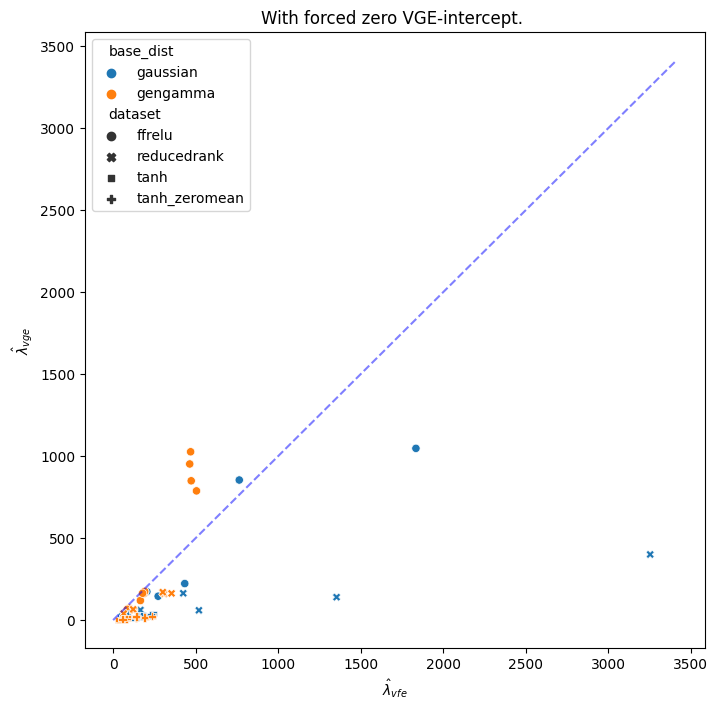

In [215]:
fig, ax = plt.subplots(figsize=(8, 8))
xvar_name = slope_var_name_dict[COL_MVFE]
yvar_name = slope_var_name_dict[COL_VGE]

sns.scatterplot(
    data=df_p,
    x=xvar_name, 
    y=yvar_name, 
    hue="base_dist", 
    style="dataset", 
#     size=COL_H, 
    legend="brief", 
    ax=ax
)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xrange = np.linspace(0, xmax, num=50)
ax.plot(xrange, xrange, "b--", alpha=0.5)

ax.set_title("With forced zero VGE-intercept. ")

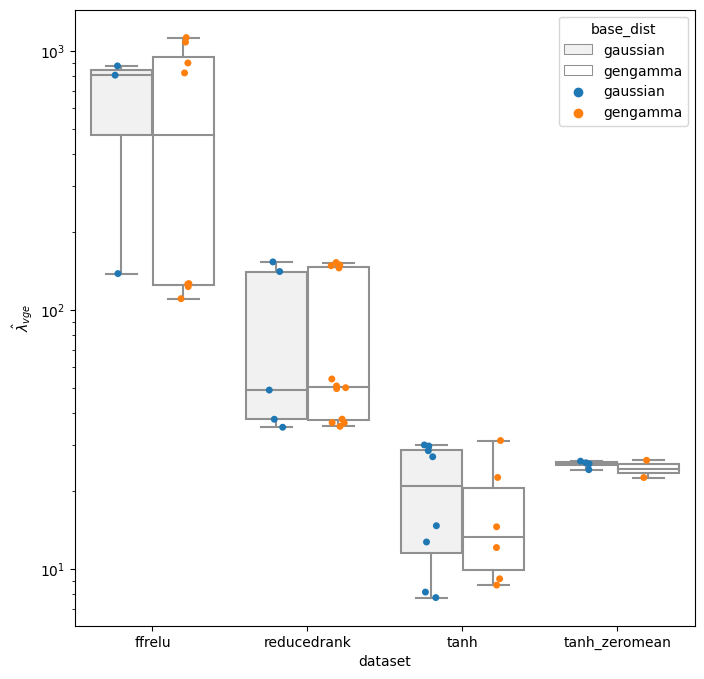

In [197]:
fig, ax = plt.subplots(figsize=(8, 8))

# v = "normalized MVFE"
v = "VGE"
sns.boxplot(
    data=df_p.reset_index(), 
    x="dataset", 
    y=slope_var_name_dict[v], 
    hue="base_dist", 
    ax=ax, 
    color="white", 
)


sns.stripplot(
    data=df_p.reset_index(), 
    x="dataset", 
    y=slope_var_name_dict[v], 
    hue="base_dist", 
    dodge=True,
    ax=ax
)


ax.set_yscale("log")

(45, 2)
(29, 2)


Text(0.5, 1.0, 'With fitted VGE-intercept. ')

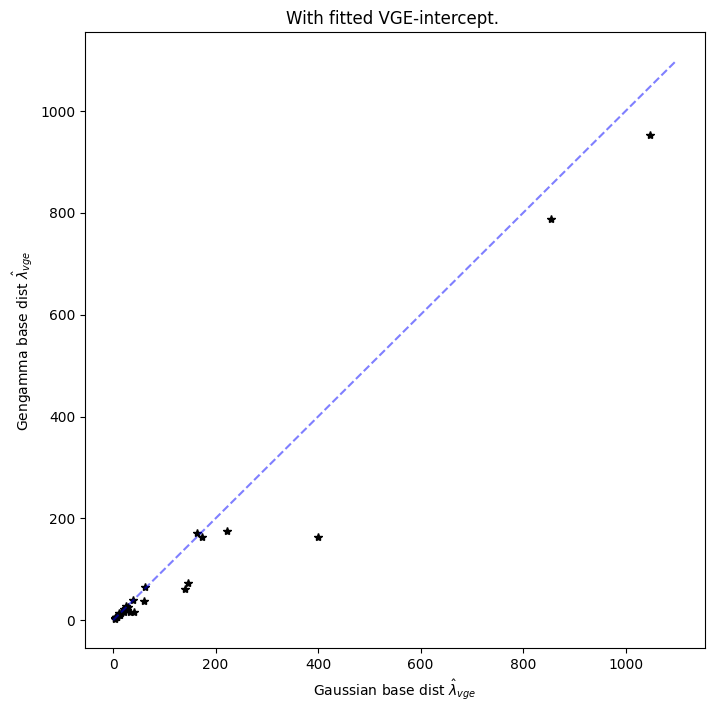

In [216]:

a = {}
for index, row in df_p.iterrows():
    dset, h, bdist, nl, nu = index
    key = '_'.join(map(str, [dset, h, nl, nu]))
    if key not in a:
        a[key] = {}
    a[key][bdist] = row[slope_var_name_dict["VGE"]]
dfx = pd.DataFrame.from_dict(a, orient="index")
print(dfx.shape)
dfx = dfx.dropna()
print(dfx.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(
    dfx["gaussian"], 
    dfx["gengamma"], 
    "k*"
)
ax.set_xlabel("Gaussian base dist $\\hat{\\lambda}_{vge}$")
ax.set_ylabel("Gengamma base dist $\\hat{\\lambda}_{vge}$");
xmax = ax.get_xlim()[1]
xrange = np.linspace(0, xmax, num=50)
ax.plot(xrange, xrange, "b--", alpha=0.5)
ax.set_title("With fitted VGE-intercept. ")

# Summarising table

In [124]:
df = df_data.reset_index()

gcols = ["dataset", COL_H, COL_DIMW, COL_LAMBDA]
g = df.groupby(gcols)
dfx = pd.DataFrame([x for x in g.groups.keys()], columns=gcols)
dfx[COL_LAMBDA] = np.around(dfx[COL_LAMBDA], 2)
dfx[COL_LAMBDA].fillna("-", inplace=True)


io_dims_rec = {
    "tanh": (1, 1), 
    "tanh_zeromean": (1, 1), 
    "ffrelu": (13, 1),
    "reducedrank": (3, 0), 
}

io_dims = []
for i, row in dfx.iterrows():
    dset = row["dataset"]
    xdim, ydim = io_dims_rec[dset]
    if dset == "reducedrank":
        xdim += row[COL_H]
        ydim += row[COL_H]
    io_dims.append((xdim, ydim))

dfx[["dim(x)", "dim(y)"]] = io_dims

def _formatter(name):
    if name == "tanh_zeromean":
        return "tanh (zero mean)"
    return name

dfx["dataset"] = [_formatter(name) for name in dfx["dataset"]]
dfx = dfx.set_index(gcols[:2]).sort_index()

print(dfx.to_latex(index=True, escape=False, formatters={"dataset": _formatter}))
dfx

\begin{tabular}{llrlrr}
\toprule
                 &     &  $dim_w$ & $\lambda$ &  dim(x) &  dim(y) \\
dataset & $H$ &          &           &         &         \\
\midrule
ffrelu & 3   &       42 &         - &      13 &       1 \\
                 & 7   &       98 &         - &      13 &       1 \\
                 & 16  &      224 &         - &      13 &       1 \\
                 & 40  &      560 &         - &      13 &       1 \\
reducedrank & 2   &       14 &       5.0 &       5 &       2 \\
                 & 7   &      119 &      35.0 &      10 &       7 \\
                 & 10  &      230 &      65.0 &      13 &      10 \\
                 & 16  &      560 &     152.0 &      19 &      16 \\
tanh & 15  &       30 &         - &       1 &       1 \\
                 & 50  &      100 &         - &       1 &       1 \\
                 & 115 &      230 &         - &       1 &       1 \\
                 & 280 &      560 &         - &       1 &       1 \\
tanh (zero mean) & 15  &    

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_5281/3754645282.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfx.to_latex(index=True, escape=False, formatters={"dataset": _formatter}))


$dim_w$ $\lambda$  dim(x)  dim(y)
dataset          $H$                                   
ffrelu           3         42         -      13       1
                 7         98         -      13       1
                 16       224         -      13       1
                 40       560         -      13       1
reducedrank      2         14       5.0       5       2
                 7        119      35.0      10       7
                 10       230      65.0      13      10
                 16       560     152.0      19      16
tanh             15        30         -       1       1
                 50       100         -       1       1
                 115      230         -       1       1
                 280      560         -       1       1
tanh (zero mean) 15        30      1.93       1       1
                 50       100      3.53       1       1
                 115      230      5.36       1       1
                 280      560      8.36       1       1

In [125]:
df = df_data.reset_index()
gcols = ["base_dist", "num_layers", "num_units", COL_DIMQ]
cols  = ["Base distribution", "Num coupling layers", "Num units", COL_DIMQ]
g = df.groupby(gcols)
dfx = pd.DataFrame([x for x in g.groups.keys()], columns=cols).set_index(cols[:3])

print(dfx.to_latex(index=True, escape=False))
dfx

\begin{tabular}{lllr}
\toprule
         &   &    &  $dim_q$ \\
Base distribution & Num coupling layers & Num units &          \\
\midrule
gaussian & 2 & 4  &     1360 \\
         &   & 4  &     2512 \\
         &   & 4  &     3376 \\
         &   & 4  &     7408 \\
         &   & 4  &     7552 \\
         &   & 4  &     8920 \\
         &   & 4  &    16480 \\
         &   & 4  &    16912 \\
         &   & 4  &    40672 \\
         &   & 16 &     8176 \\
         &   & 16 &    12400 \\
         &   & 16 &    15568 \\
         &   & 16 &    30352 \\
         &   & 16 &    30880 \\
         &   & 16 &    35896 \\
         &   & 16 &    63616 \\
         &   & 16 &    65200 \\
         &   & 16 &   152320 \\
         & 4 & 4  &     2720 \\
         &   & 4  &     5024 \\
         &   & 4  &     6752 \\
         &   & 4  &    14816 \\
         &   & 4  &    15104 \\
         &   & 4  &    17840 \\
         &   & 4  &    32960 \\
         &   & 4  &    33824 \\
         &   & 4  &    81344 \

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_5281/3858583038.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfx.to_latex(index=True, escape=False))


$dim_q$
Base distribution Num coupling layers Num units         
gaussian          2                   4             1360
                                      4             2512
                                      4             3376
                                      4             7408
                                      4             7552
...                                                  ...
gengamma          4                   16           61760
                                      16           71792
                                      16          127232
                                      16          130400
                                      16          304640

[72 rows x 1 columns]